# Librerías necesarias

In [25]:
import sys
sys.path.append('../..')

from utils import load_cinema_reviews

import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

import matplotlib.pyplot as plt

# Carga de datos

In [2]:
# Path al directorio donde tenemos los datasets con las reviews
# ¡Descomprimir antes!
datasets_path = '../../datasets'
corpus_cine_folder = 'corpusCine'

In [3]:
reviews_dict = load_cinema_reviews(datasets_path, corpus_cine_folder)

In [4]:
reviews_dict.get(10)

{'author': 'Javier Moreno',
 'title': 'Harry poter y el caliz de fuego',
 'sentiment': '4',
 'summary': 'Interesante adaptación de la novela de Rowling',
 'review_text': 'No. Esta vez no voy a usar una película como pretexto para exponer mis ideas o pensamientos mas dementes/racionales/insensatos. Esta vez, y lo juro ante el sagrado Necronomicón de Lovecraft, pienso hablar de la película en si (por primera vez y esperando que no sirva de precedente), aunque creo que es evidente que prefiero que una película me haga reflexionar sobre cualquier aspecto que en ella se de cita. Quizas algún dia hable sobre todo lo que significa la saga de novelas de Rowling (anda que no tengo cosas de las que hablar) desde una perspectiva menos mitológica y mas profunda.Parto de la base de que soy un autentico fan de los libros, los adoro, me parecen de lo mejorcito que ha salido en fantasia, con un personaje principal realmente interesante y atormentado a todos los niveles por todo lo que su no-existencia

In [5]:
reviews_text = []
reviews_sentiment = []

for review in reviews_dict.values():
    reviews_text.append(review.get('review_text'))
    reviews_sentiment.append(review.get('sentiment'))

df = pd.DataFrame({
    'review': reviews_text,
    'sentiment': reviews_sentiment
})
df.dropna(subset=['review', 'sentiment'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df.head()

,review,sentiment
0,Cada vez me gusta menos el cine de masas. Las ...,1
1,"El otro dia fui a ver ""la de los sioux"" como d...",3
2,"Es que no la cagan en ninguna, todas las pelis...",5
3,Es un dolor esto del cine. Yo ya voy con miedo...,2
4,"Tras una insufrible primera media hora, la cas...",2


In [7]:
def label_sentiment(row):
    if int(row['sentiment']) < 3:
        return 1
    else:
        return 0

In [8]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [9]:
df.head()

,review,sentiment,sentiment_label
0,Cada vez me gusta menos el cine de masas. Las ...,1,1
1,"El otro dia fui a ver ""la de los sioux"" como d...",3,0
2,"Es que no la cagan en ninguna, todas las pelis...",5,0
3,Es un dolor esto del cine. Yo ya voy con miedo...,2,1
4,"Tras una insufrible primera media hora, la cas...",2,1


# Separamos en conjunto de train y test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [11]:
X_train.iloc[:10]

1924    Zhang Yimou ya no es el poeta de lo íntimo, el...
3250    Las aventuras amorosas del joven Molire es el ...
1620    El cientifismo naturalista es un género cinema...
907     Quizá esperaba una crítica más demoledora del ...
1864    Colateral de Michael Mann desnuda con claridad...
3007    No es Gracia Querejeta una directora a la que ...
1583    Esta es una de esas extrañas películas que emp...
370     Suele ocurrir que cuando alguien pone las expe...
2045    Vivian vive en Bucarest, trabaja en una tienda...
3601    Algunos filmes pasan a ser de culto por un hec...
Name: review, dtype: object

In [12]:
y_train.iloc[:10]

1924    0
3250    0
1620    1
907     1
1864    0
3007    0
1583    0
370     0
2045    1
3601    1
Name: sentiment_label, dtype: int64

# Extracción de features

In [13]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=2500,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=5, strip_accents='ascii')

In [14]:
print(list(cv.vocabulary_.items())[:20])

[('ya', 2493), ('lo', 1349), ('director', 683), ('alla', 102), ('primeros', 1845), ('ahora', 83), ('visual', 2460), ('maestro', 1376), ('cuyo', 561), ('talento', 2248), ('consiste', 457), ('belleza', 235), ('ejercicio', 748), ('bajo', 215), ('forma', 973), ('entender', 782), ('cine', 368), ('acostumbrados', 49), ('esta', 852), ('al', 86)]


In [15]:
print(len(cv.vocabulary_))

2500


## TF-IDF scores del training set y test set

In [16]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

## Score IDF de algunas palabras

In [17]:
words_example = [
    'cine',
    'pelicula',
    'muy',
    'y',
    'de',
    'que',
    'potter',
    'mala',
    'aburrimiento',
    'sorprendente',
    'aburrir',
    'ausdf'
]

In [18]:
vocab_idf = dict(zip(cv.get_feature_names(), cv.idf_))

print('{0:20}{1:20}'.format('Palabra', 'IDF'))
for word in words_example:
    if word not in vocab_idf:
        print('{0:20}{1:20}'.format(word, 'OOV'))
    else:
        print('{0:20}{1:2.3f}'.format(word, vocab_idf[word]))

Palabra             IDF                 
cine                1.556
pelicula            1.154
muy                 1.532
y                   OOV                 
de                  OOV                 
que                 OOV                 
potter              5.005
mala                3.155
aburrimiento        4.727
sorprendente        4.275
aburrir             OOV                 
ausdf               OOV                 


## Palabras con el TF-IDF en alguna review

In [19]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 1231
Sentiment: 1
Review: El cine es el hogar de las leyendas. En el celuloide nacen, crecen, se multiplican con innecesarias secuelas y precuelas, y si algún día llegan a morir, es que nunca merecieron semejante consideración. Vemos personajes con los que desearíamos tomar una copa, a los que nos gustaría llegar a conocer, y por los que probablemente sentimos un cariño especial. Para una generación, Rocky Balboa es una leyenda. Tardíamente, para mí también. Y sí, influye mi particular pasión por el boxeo y el subgénero cinematográfico que ha creado este deporte. Yo soy de emocionarme con Paul Newman en "Marcado por el odio", por Robert de Niro en "Toro Salvaje", e incluso por Russell Crowe en "Cinderella Man". Guiño especial para el Robert Ryan de "The Set-Up", del maestro Robert Wise."Rocky" (1976) nos (me) conmovió por ser la típica historia de un tipo normal, del montón tirando a poca cosa. Era un personaje al que le ofrecieron un puñado de dólares para que un campeón de boxeo 

In [20]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 1231:
             tfidf
rocky     0.604635
leyenda   0.235880
recordar  0.168153
por       0.149853
stallone  0.144281
robert    0.143945
daba      0.126774
cosa      0.106265
aquella   0.099079
sino      0.094289

Top 10 words with lowest TF_IDF in the review 1231:
         tfidf
me    0.021220
ser   0.020339
cine  0.020136
ha    0.019951
ya    0.019515
este  0.019172
sus   0.018471
sin   0.018383
todo  0.018148
como  0.014111


## $\chi²$ scores

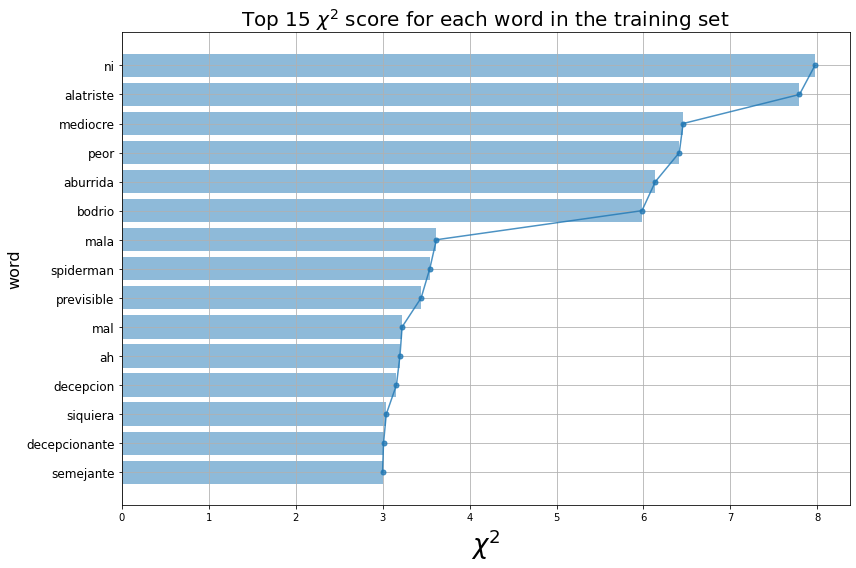

In [21]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

# Entrenamiento

In [22]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.6597938144329897
Accuracy for C=0.05: 0.6597938144329897
Accuracy for C=0.25: 0.6876288659793814
Accuracy for C=0.5: 0.7381443298969073
Accuracy for C=1: 0.765979381443299
Accuracy for C=10: 0.7896907216494845
Accuracy for C=100: 0.7855670103092783
Accuracy for C=1000: 0.7680412371134021
Accuracy for C=10000: 0.756701030927835


# Algunas métricas

In [23]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[543  97]
 [139 191]]

Classification report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       640
           1       0.66      0.58      0.62       330

    accuracy                           0.76       970
   macro avg       0.73      0.71      0.72       970
weighted avg       0.75      0.76      0.75       970

Accuracy score:0.756701030927835


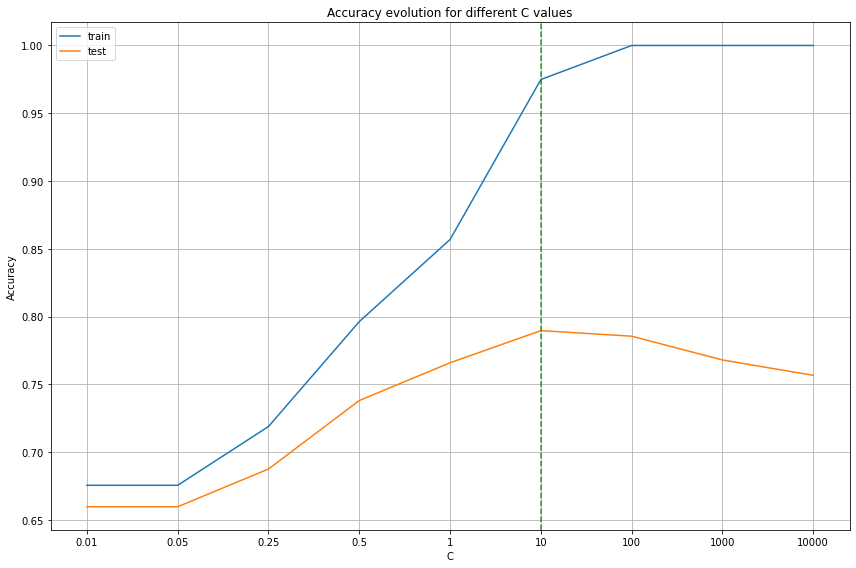

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.axvline(np.argmax(test_acc), c='g', ls='--', alpha=0.8)
plt.title('Accuracy evolution for different C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.xticks(list(range(len(c_params))), c_params)
plt.tight_layout()
plt.show()

In [27]:
p, r, thresholds = precision_recall_curve(y_test, test_predict)

In [28]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

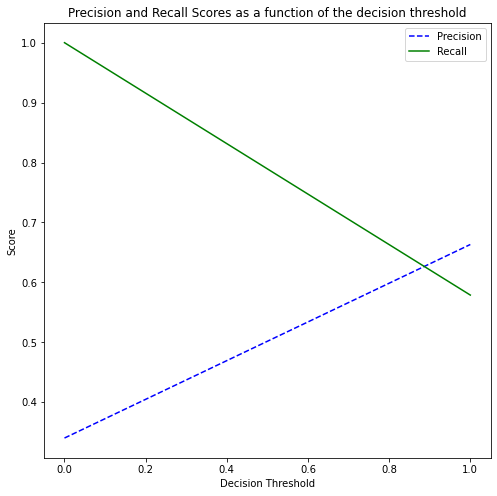

In [29]:
plot_precision_recall_vs_threshold(p, r, thresholds)

# Predict

In [50]:
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(df.iloc[review_index]['sentiment_label']))
    r = df.iloc[review_index]['review']
    print('Prediction: {}'.format(lr.predict(cv.transform([r]))))

In [51]:
for i in random.sample(range(0, len(df)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, lr)


Review no. 1991
Actual sentiment: 0
Prediction: [0]

Review no. 1106
Actual sentiment: 0
Prediction: [0]

Review no. 1634
Actual sentiment: 0
Prediction: [0]

Review no. 3528
Actual sentiment: 0
Prediction: [0]

Review no. 1606
Actual sentiment: 1
Prediction: [1]
